# DM-27813 Crowded Fields to Zooniverse

In [1]:
import functools
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import cm
import os
import pandas as pd
import sqlite3
from astropy.visualization import simple_norm

import panoptes_client

import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

import lsst.geom
from lsst.ip.diffim import GetCoaddAsTemplateTask

# local to ap_pipe-notebooks
import plotLightcurve
import apdbPlots

In [2]:
# The gen2 butler repos containing the templates and difference images, respectively.
parent = "/project/sullivan/saha/cwcoadds_processed"
REPO = '/project/sullivan/saha/ap_pipe/cw/'

In [3]:
# The URL where the output files can be accessed by zooniverse.
url_root = "https://lsst.ncsa.illinois.edu/~parejkoj/zooniverse/"
# The path to write the PNG and manifest files to.
output_path = "/scratch/parejkoj/zooniverse/"

In [4]:
connection = sqlite3.connect(f'{REPO}/association.db')

In [5]:
butler = dafPersist.Butler(inputs=[REPO, parent])

First we want to get a random subset of DIASources from the APDB.

In [10]:
%%time 
# to get a random sample: ORDER BY RANDOM() 
ds_sample = pd.read_sql_query('select * from DiaSource LIMIT 100;', connection)

CPU times: user 34.5 ms, sys: 1.79 ms, total: 36.3 ms
Wall time: 34.3 ms


In [11]:
ds_sample.flags

0     25299404
1     31066572
2     25168328
3     31066600
4     31066568
        ...   
95    25165864
96    41944360
97        1320
98    25167144
99    41944360
Name: flags, Length: 100, dtype: int64

In [7]:
apdbPlots.addVisitCcdToSrcTable(ds_sample)

,diaSourceId,ccdVisitId,diaObjectId,ssObjectId,parentDiaSourceId,prv_procOrder,ssObjectReassocTime,midPointTai,ra,raErr,...,extendedness,spuriousness,flags,pixelId,filterName,filterId,isDipole,bboxSize,ccd,visit
0,184157035032479591,42877401,184157035032479591,0,0,0,None,57116.286309,270.371311,None,...,None,None,25299404,0,g,1,0,33,01,428774
1,184157035032479592,42877401,184157035032479592,0,0,0,None,57116.286309,270.370908,None,...,None,None,31066572,0,g,1,0,36,01,428774
2,184157035032479593,42877401,184157035032479593,0,0,0,None,57116.286309,270.372414,None,...,None,None,25168328,0,g,1,0,48,01,428774
3,184157035032479594,42877401,184157035032479594,0,0,0,None,57116.286309,270.370768,None,...,None,None,31066600,0,g,1,0,26,01,428774
4,184157035032479595,42877401,184157035032479595,0,0,0,None,57116.286309,270.370701,None,...,None,None,31066568,0,g,1,0,17,01,428774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,184157035032479686,42877401,184157035032479686,0,0,0,None,57116.286309,270.390668,None,...,None,None,25165864,0,g,1,0,15,01,428774
96,184157035032479687,42877401,184157035032479687,0,0,0,None,57116.286309,270.390280,None,...,None,None,41944360,0,g,1,1,21,01,428774
97,184157035032479688,42877401,184157035032479688,0,0,0,None,57116.286309,270.390002,None,...,None,None,1320,0,g,1,0,14,01,428774
98,184157035032479689,42877401,184157035032479689,0,0,0,None,57116.286309,270.390061,None,...,None,None,25167144,0,g,1,0,16,01,428774


## Get calexp, template, and difference cutouts for each source

In [6]:
# @functools.lru_cache()
# NOTE: dataId is a dict, which is not hashable thus not cacheable
def get_images(dataId):
    exposure = butler.get('calexp', dataId)
    difference = butler.get('deepDiff_differenceExp', dataId)
    template = butler.get('deepDiff_warpedExp', dataId)
    return exposure, difference, template

def get_cutouts(dataId, center, size=lsst.geom.Extent2I(30, 30)):
    """Return a cutout for this dataId at the given source location."""
    # TODO: We can make this a lot faster by loading the images for every "ccd/visit" combo,
    # TODO: and then making the cutouts at each source that lies on that ccd.
    exposure, difference, template = get_images(dataId)
    return exposure.getCutout(center, size), difference.getCutout(center, size), template.getCutout(center, size)

In [10]:
# an example dataId and center for playing with making a single image.
i=50
dataId={'ccd': int(ds_sample['ccd'][i]), 'visit': int(ds_sample['visit'][i])}
center=lsst.geom.SpherePoint(ds_sample['ra'][i], ds_sample['decl'][i], lsst.geom.degrees)
exposure, difference, template = get_cutouts(dataId, center)

## Plot the images

In [7]:
def plot_cutout(science, difference, template, output=None):
    """Plot the cutouts for a source in one image.
    """
    Qst=15 #Q for Science and Template
    sst=4 #Stretch for Science and Template
    Qd=5 #Q for Difference
    sd=50 #Stretch for Difference
    asinst=0.01
    asind=0.7

    def do_one(ax, data, name):
        norm = simple_norm(data, stretch="asinh", asinh_a=0.05)
        ax.imshow(data, cmap=cm.inferno, interpolation="none", norm=norm)
        ax.axis('off')
        ax.set_title(name)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    do_one(ax1, template.image.array, "Template")
    do_one(ax2, science.image.array, "Science")
    do_one(ax3, difference.image.array, "Difference")
    plt.tight_layout()

    if output is not None:
        plt.savefig(output, bbox_inches="tight")
        plt.close()

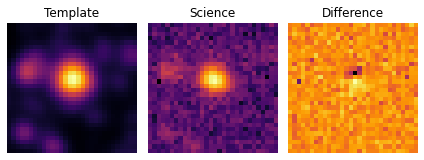

In [37]:
plot_cutout(exposure, difference, template)

## Generate manifest information for upload to Zooniverse

In [8]:
def make_manifest(data, url_root):
    output = pd.DataFrame([])
    output['uuid'] = data['diaSourceId']
    output['location:1'] = ds_sample.apply(lambda x: f"{url_root}{x['diaSourceId']}.png", axis=1)
    output['metadata:diaSourceId'] = data['diaSourceId']
    return output

## Make plots for every source

In [18]:
# TODO: as currently written, this is going to be *very* slow because it re-loads the images for every source.
for index,source in ds_sample.iterrows():
    center = lsst.geom.SpherePoint(source['ra'], source['decl'], lsst.geom.degrees)
    dataId = {'ccd': int(source['ccd']), 'visit': int(source['visit'])}
    exposure, difference, template = get_cutouts(dataId, center)
    filename = f"{source['diaSourceId']}.png"
    plot_cutout(exposure, difference, template, output=f"{output_path}{filename}")

TypeError: unhashable type: 'dict'

## Submit data to Panoptes

In [12]:
manifest = make_manifest(ds_sample, url_root)
manifest.to_csv(os.path.join(output_path, "manifest.csv"))
manifest.to_json(os.path.join(output_path, "manifest.json"))

In [13]:
client = panoptes_client.Panoptes.connect(login="interactive")

Enter your Zooniverse credentials...


Username:  parejkoj
 ········


In [15]:
project = panoptes_client.Project.find(slug='ebellm/alert-production-zoo')

In [16]:
print([(ss.id, ss.display_name) for ss in project.links.subject_sets])

[('80863', 'HiTS'), ('81026', 'HSC-COSMOS')]


In [19]:
# make a new subject set
subject_set = panoptes_client.SubjectSet()

subject_set.links.project = project
subject_set.display_name = 'saha'

subject_set.save()

{'subject_sets': [{'id': '90418',
   'display_name': 'saha',
   'set_member_subjects_count': 0,
   'metadata': {},
   'created_at': '2020-12-15T09:51:55.915Z',
   'updated_at': '2020-12-15T09:51:55.950Z',
   'href': '/subject_sets/90418',
   'links': {'project': '11152', 'workflows': [], 'subjects': []}}],
 'links': {'subject_sets.project': {'href': '/projects/{subject_sets.project}',
   'type': 'projects'},
  'subject_sets.workflows': {'href': '/workflows?subject_set_id={subject_sets.id}',
   'type': 'workflows'}},
 'meta': {'subject_sets': {'page': 1,
   'page_size': 20,
   'count': 1,
   'include': [],
   'page_count': 1,
   'previous_page': None,
   'next_page': None,
   'first_href': '/subject_sets',
   'previous_href': None,
   'next_href': None,
   'last_href': '/subject_sets'}}}

In [20]:
project.reload()